In [2]:
import pydicom
import nibabel as nib
import numpy as np
import os

def dicom_to_nifti(dicom_folder, output_path):
    # Load all DICOM files from the folder
    dicom_files = [pydicom.dcmread(os.path.join(dicom_folder, f)) for f in os.listdir(dicom_folder) if f.endswith('.dcm')]

    # Sort files by the Slice Location
    dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    # Extract image data and metadata
    pixel_data = [d.pixel_array for d in dicom_files]
    pixel_array = np.stack(pixel_data, axis=-1)  # Stack into a 3D array

    # Create NIfTI image
    affine = np.eye(4)  # Placeholder affine; modify if needed
    nifti_image = nib.Nifti1Image(pixel_array, affine)
    nib.save(nifti_image, output_path)
    print(f"NIfTI file saved to: {output_path}")

# Usage
dicom_folder = '../Dataset/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578'
output_path = 'output.nii'
dicom_to_nifti(dicom_folder, output_path)

NIfTI file saved to: output.nii


In [3]:
img = nib.load(output_path)

# Access the image data as a NumPy array
img_data = img.get_fdata()  # or use img.get_data() for older versions of nibabel

# Display some information about the data
print("Shape:", img_data.shape)
print("Data type:", img_data.dtype)

Shape: (1024, 1024, 179)
Data type: float64


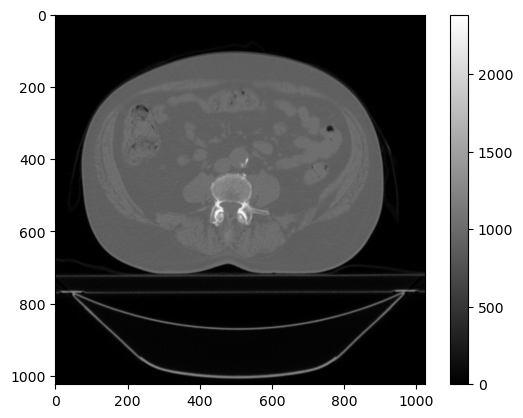

In [6]:
import matplotlib.pyplot as plt

# Display a middle slice along the third axis
slice_index = 178
plt.imshow(img_data[:, :, slice_index], cmap="gray")
plt.colorbar()
plt.show()

In [8]:
import pydicom
import nibabel as nib
import numpy as np
import SimpleITK as sitk
from skimage.draw import polygon

def get_affine(image):
    """Generate a 4x4 affine matrix from a SimpleITK image object."""
    # Get spacing, direction, and origin from SimpleITK image
    spacing = image.GetSpacing()
    direction = np.array(image.GetDirection()).reshape(3, 3)
    origin = image.GetOrigin()

    # Scale the direction matrix by spacing
    affine_3x3 = direction * spacing

    # Construct the full 4x4 affine matrix
    affine = np.eye(4)
    affine[:3, :3] = affine_3x3
    affine[:3, 3] = origin

    return affine

def convert_rtstruct_to_nifti(rtstruct_file, dicom_image_folder, output_nifti_file):
    # Load the RTSTRUCT file
    rtstruct = pydicom.dcmread(rtstruct_file)
    
    # Load the corresponding DICOM image series as a 3D volume
    reader = sitk.ImageSeriesReader()
    dicom_files = reader.GetGDCMSeriesFileNames(dicom_image_folder)
    reader.SetFileNames(dicom_files)
    image = reader.Execute()
    image_array = sitk.GetArrayFromImage(image)  # shape: (num_slices, height, width)

    # Get the affine matrix
    affine = get_affine(image)

    # Create an empty binary mask volume
    mask_volume = np.zeros_like(image_array, dtype=np.uint8)

    # Parse structures from RTSTRUCT
    for roi in rtstruct.StructureSetROISequence:
        roi_number = roi.ROINumber
        roi_name = roi.ROIName
        
        # Find contour data for the ROI
        contours = [c for c in rtstruct.ROIContourSequence if c.ReferencedROINumber == roi_number]
        if not contours:
            continue
        
        # Process each contour sequence
        for contour_seq in contours[0].ContourSequence:
            # Get contour coordinates
            contour_data = contour_seq.ContourData
            points = np.array(contour_data).reshape(-1, 3)
            
            # Map contour points to pixel indices
            slice_index = int(np.argmin(np.abs(image.GetOrigin()[2] + np.arange(image_array.shape[0]) * image.GetSpacing()[2] - points[0, 2])))
            row_indices, col_indices = polygon(points[:, 1], points[:, 0], shape=image_array.shape[1:])
            
            # Fill in the mask volume at the slice
            mask_volume[slice_index, row_indices, col_indices] = 1

    # Convert to a NIfTI image and save
    nifti_image = nib.Nifti1Image(mask_volume, affine)
    nib.save(nifti_image, output_nifti_file)
    print(f"Saved NIfTI mask to {output_nifti_file}")

# Usage
rtstruct_file = '../Dataset/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/0.000000-Contouring-60430/1-1.dcm'
convert_rtstruct_to_nifti(rtstruct_file, dicom_folder, output_path)

Saved NIfTI mask to output.nii


In [9]:
import nibabel as nib

# Load the NIfTI file
nifti_file_path = 'output.nii'
nifti_image = nib.load(nifti_file_path)

# Get the data as a numpy array
image_data = nifti_image.get_fdata()
affine = nifti_image.affine  # Get the affine matrix if needed

# Display basic information
print("Image shape:", image_data.shape)
print("Affine matrix:\n", affine)

Image shape: (179, 1024, 1024)
Affine matrix:
 [[ 4.54101562e-01  0.00000000e+00  0.00000000e+00 -2.32500000e+02]
 [ 0.00000000e+00  4.54101562e-01  0.00000000e+00 -9.15000000e+01]
 [ 0.00000000e+00  0.00000000e+00  2.00000000e+00 -1.24350000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


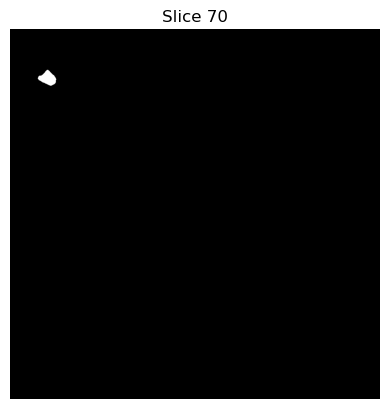

In [13]:
import matplotlib.pyplot as plt

# Display a middle slice
slice_index = 70  # Get the middle slice
plt.imshow(image_data[slice_index,:, :], cmap="gray")
plt.title(f"Slice {slice_index}")
plt.axis("off")
plt.show()

In [ ]:
from platipy.dicom.io.rtstruct import convert_rtstruct

convert_rtstruct(dicom_folder, rtstruct_file, prefix='Struct', output_dir='notebooks/test', output_img=None, spacing=None, replace_slashes_with='')

ImportError: cannot import name 'rtstructto_nifti' from 'platipy.dicom.io' (C:\Users\Carole\AppData\Roaming\Python\Python312\site-packages\platipy\dicom\io\__init__.py)